# Facial Pose Analysis Pipeline

This notebook provides a comprehensive analysis pipeline for facial pose data from OpenPose landmark detection. The pipeline includes quality control, preprocessing, feature extraction, and statistical analysis.

## Overview

The analysis workflow consists of several key stages:

1. **Quality Control**: Identify and mask unreliable landmark data
2. **Coordinate Normalization**: Apply Procrustes alignment or original stabilization
3. **Feature Extraction**: Compute facial features (blinks, mouth movement, head pose)
4. **Temporal Filtering**: Apply smoothing to reduce noise
5. **Statistical Analysis**: Generate summary statistics and visualizations

Each stage is thoroughly documented and uses modular utility functions for reproducibility.

---

## 1. Setup and Configuration

First, we'll import all necessary libraries and set up our analysis parameters.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings

# Import our custom pose analysis utilities
from utils.pipeline import run_complete_pose_pipeline, process_single_file
from utils.quality_control import (
    run_quality_control_batch, 
    summarize_quality_control
)
from utils.coordinate_normalization import compute_procrustes_alignment
from utils.feature_extraction import extract_all_features, extract_features_flexible
from utils.temporal_filtering import apply_butterworth_filter
from utils.statistical_analysis import (
    apply_z_score_normalization,
    calculate_summary_statistics,
    calculate_correlation_matrix,
    compare_groups_statistical,
    perform_feature_analysis,
    calculate_feature_summary_by_condition
)
from utils.plotting import (
    plot_qc_summary,
    plot_feature_timeseries,
    plot_correlation_matrix,
    plot_normalization_comparison,
    generate_visual_report,
    plot_statistical_bars,
    plot_feature_comparison_matrix
)
from utils.data_loading import (
    load_participant_info,
    parse_condition_mapping,
    load_pose_data_with_conditions,
    prepare_data_for_statistical_analysis
)
from utils.landmark_config import QC_TO_FEATURE_COLUMNS

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")
print("✓ Pose analysis utilities loaded")
print("✓ Plotting configuration set")

✓ Libraries imported successfully
✓ Pose analysis utilities loaded
✓ Plotting configuration set


### Analysis Parameters

Configure the key parameters for our analysis pipeline. These parameters control every aspect of the processing from quality control through final feature extraction.

In [2]:
# =============================================================================
# ANALYSIS CONFIGURATION PARAMETERS
# =============================================================================

# Directory paths
RAW_DATA_DIR = "../data/example_pose_data"              # Input: Raw OpenPose CSV files
OUTPUT_BASE_DIR = "data/processed"          # Output: All processed data
FIGURES_DIR = "output/figures"              # Output: Plots and visualizations

# Quality Control Parameters
QC_WINDOW_SIZE = 1800                       # Frames per QC window (30s at 60fps)
QC_OVERLAP = 0.0                           # Window overlap fraction (0.0 = no overlap)
CONFIDENCE_THRESHOLD = 0.3                  # Minimum landmark confidence
MAX_INTERPOLATION = 60                      # Max consecutive frames to interpolate

# Processing Parameters
COORDINATE_SYSTEM = "procrustes"            # "procrustes" or "original"
APPLY_TEMPORAL_FILTER = True               # Apply Butterworth smoothing
SAMPLING_RATE = 60.0                       # Data sampling rate (Hz)
CUTOFF_FREQUENCY = 10.0                    # Butterworth cutoff frequency (Hz)
FILTER_ORDER = 4                           # Butterworth filter order

# Create output directories
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print("POSE ANALYSIS CONFIGURATION")
print("=" * 50)
print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"Output directory: {OUTPUT_BASE_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"")
print(f"Quality Control:")
print(f"  Window size: {QC_WINDOW_SIZE} frames ({QC_WINDOW_SIZE/60:.1f} seconds)")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"  Max interpolation: {MAX_INTERPOLATION} frames")
print(f"")
print(f"Processing:")
print(f"  Coordinate system: {COORDINATE_SYSTEM}")
print(f"  Temporal filtering: {APPLY_TEMPORAL_FILTER}")
if APPLY_TEMPORAL_FILTER:
    print(f"  Filter cutoff: {CUTOFF_FREQUENCY} Hz")
    print(f"  Sampling rate: {SAMPLING_RATE} Hz")

POSE ANALYSIS CONFIGURATION
Raw data directory: ../data/example_pose_data
Output directory: data/processed
Figures directory: output/figures

Quality Control:
  Window size: 1800 frames (30.0 seconds)
  Confidence threshold: 0.3
  Max interpolation: 60 frames

Processing:
  Coordinate system: procrustes
  Temporal filtering: True
  Filter cutoff: 10.0 Hz
  Sampling rate: 60.0 Hz


## 2. Run Complete Pipeline

Execute the complete processing pipeline which includes quality control, feature extraction, and filtering.

In [3]:
# Check for data files and run pipeline
if os.path.exists(RAW_DATA_DIR):
    csv_files = [f for f in os.listdir(RAW_DATA_DIR) if f.endswith('.csv')]
    print(f"Found {len(csv_files)} CSV files in {RAW_DATA_DIR}")
    
    if csv_files:
        # Run complete pipeline
        output_paths = run_complete_pose_pipeline(
            raw_input_dir=RAW_DATA_DIR,
            output_base_dir=OUTPUT_BASE_DIR,
            window_size=QC_WINDOW_SIZE,
            overlap=QC_OVERLAP,
            confidence_threshold=CONFIDENCE_THRESHOLD,
            max_interpolation=MAX_INTERPOLATION,
            coordinate_system=COORDINATE_SYSTEM,
            apply_temporal_filter=APPLY_TEMPORAL_FILTER,
            sampling_rate=SAMPLING_RATE,
            cutoff_frequency=CUTOFF_FREQUENCY,
            filter_order=FILTER_ORDER
        )
    else:
        print("No CSV files found. Please add your raw pose data files.")
else:
    print(f"Directory {RAW_DATA_DIR} does not exist. Please create it and add data files.")

Found 5 CSV files in ../data/example_pose_data
FACIAL POSE PROCESSING PIPELINE
Input directory: ../data/example_pose_data
Output directory: data/processed
Coordinate system: procrustes
Temporal filtering: True

STEP 1: Running Quality Control Analysis...
----------------------------------------


QC Analysis: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]



Quality Control Results Saved:
  Keypoint statistics: data/processed/quality_control/keypoint_bad_windows.csv
  Metric statistics: data/processed/quality_control/metric_bad_windows.csv
  Bad window details: data/processed/quality_control/metric_bad_window_indices.csv

STEP 2: Loading Quality Control Results...
----------------------------------------
  No bad windows detected in quality control (excellent data quality!)

STEP 3: Processing Individual Files...
----------------------------------------


Processing files:   0%|          | 0/5 [00:00<?, ?it/s]

  Processing 3101_01_pose.csv: 30598 frames
    Applying Procrustes alignment...
Applying Procrustes alignment to 30598 frames using 4 landmarks...
Procrustes alignment completed. Added _proc columns for 4 landmarks.
    Extracting features...
    Applying QC masks...
    Applying temporal filtering...


Processing files:  20%|██        | 1/5 [00:15<01:00, 15.06s/it]

    Saved to: data/processed/feature_data/3101_01_pose.csv
  Processing 3102_01_pose.csv: 30599 frames
    Applying Procrustes alignment...
Applying Procrustes alignment to 30599 frames using 4 landmarks...
Procrustes alignment completed. Added _proc columns for 4 landmarks.
    Extracting features...
    Applying QC masks...
    Applying temporal filtering...


Processing files:  40%|████      | 2/5 [00:30<00:46, 15.48s/it]

    Saved to: data/processed/feature_data/3102_01_pose.csv
  Processing 3101_02_pose.csv: 30598 frames
    Applying Procrustes alignment...
Applying Procrustes alignment to 30598 frames using 4 landmarks...
Procrustes alignment completed. Added _proc columns for 4 landmarks.
    Extracting features...
    Applying QC masks...
    Applying temporal filtering...


Processing files:  60%|██████    | 3/5 [00:46<00:31, 15.60s/it]

    Saved to: data/processed/feature_data/3101_02_pose.csv
  Processing 3101_03_pose.csv: 30598 frames
    Applying Procrustes alignment...
Applying Procrustes alignment to 30598 frames using 4 landmarks...
Procrustes alignment completed. Added _proc columns for 4 landmarks.
    Extracting features...
    Applying QC masks...
    Applying temporal filtering...


Processing files:  80%|████████  | 4/5 [01:02<00:15, 15.85s/it]

    Saved to: data/processed/feature_data/3101_03_pose.csv
  Processing 3102_02_pose.csv: 30599 frames
    Applying Procrustes alignment...
Applying Procrustes alignment to 30599 frames using 4 landmarks...
Procrustes alignment completed. Added _proc columns for 4 landmarks.
    Extracting features...
    Applying QC masks...
    Applying temporal filtering...


Processing files: 100%|██████████| 5/5 [01:18<00:00, 15.78s/it]

    Saved to: data/processed/feature_data/3102_02_pose.csv

STEP 4: Generating Reports...
----------------------------------------
Summary statistics:
  total_files_processed: 5
  successful_files: 5
  failed_files: 0
  total_frames: 764960
  total_masked_frames: 0
  overall_masking_rate: 0.0
  coordinate_system: procrustes
  temporal_filtering: True

PIPELINE COMPLETE
Output locations:
  qc_dir: data/processed/quality_control
  feature_dir: data/processed/feature_data
  reports_dir: data/processed/reports
  keypoint_qc: data/processed/quality_control/keypoint_bad_windows.csv
  metric_qc: data/processed/quality_control/metric_bad_windows.csv
  bad_windows: data/processed/quality_control/metric_bad_window_indices.csv
  processing_report: data/processed/reports/processing_report.csv
  summary: data/processed/reports/processing_summary.txt


## 3. Analysis and Visualization

Load and analyze the processed features.

Found 5 processed feature files
Loaded original data for comparison

Sample file: 3101_01_pose.csv
Shape: (30598, 26)
Features: ['center_face_x', 'center_face_y', 'center_face_prob', 'left_eye_x', 'left_eye_y', 'left_eye_prob', 'right_eye_x', 'right_eye_y', 'right_eye_prob', 'left_pupil_x']...

Basic statistics:
         blink_dist    mouth_dist  head_rotation_angle
count  30598.000000  30598.000000         30598.000000
mean       0.421613      0.391538             0.036677
std        0.103133      1.291721             0.023072
min        0.080791     -0.781065            -0.090236
25%        0.360304     -0.001570             0.023673
50%        0.399123      0.017282             0.041487
75%        0.449376      0.350701             0.052343
max        1.254839     26.878818             0.122019
Time series plot saved to: output/figures/sample_features_comparison.png

Visualization shows:
  - Solid blue line: Processed/normalized features
  - Dashed gray line: Original non-normalized

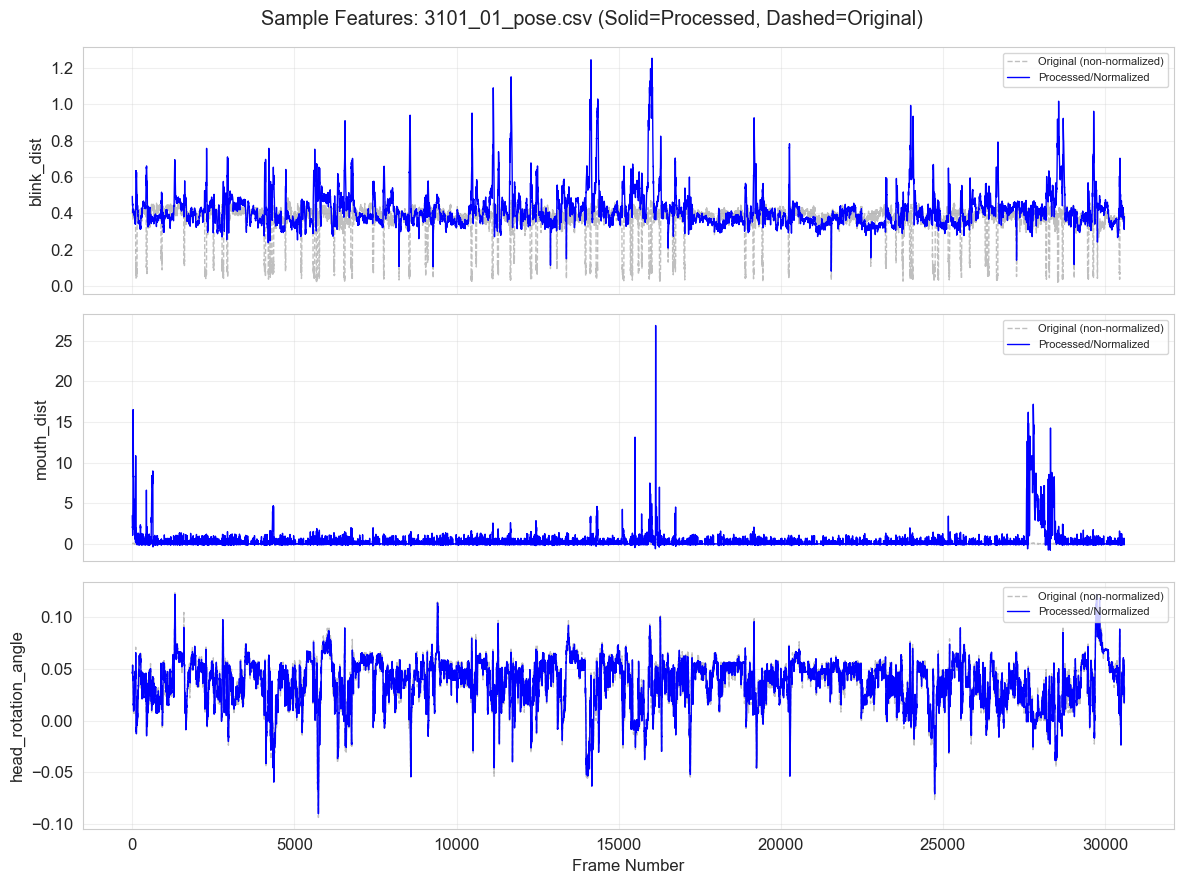

In [4]:
# Load processed features for analysis
if 'output_paths' in locals():
    feature_dir = output_paths['feature_dir']
    
    if os.path.exists(feature_dir):
        feature_files = [f for f in os.listdir(feature_dir) if f.endswith('.csv')]
        print(f"Found {len(feature_files)} processed feature files")
        
        if feature_files:
            # Load first file as example
            sample_file = os.path.join(feature_dir, feature_files[0])
            df_processed = pd.read_csv(sample_file)
            
            # Also load the original raw data for comparison
            raw_sample_file = os.path.join(RAW_DATA_DIR, feature_files[0])
            df_raw = None
            if os.path.exists(raw_sample_file):
                df_raw_data = pd.read_csv(raw_sample_file)
                # Extract features from raw data without normalization
                from utils.feature_extraction import extract_all_features
                df_raw = extract_all_features(
                    df_raw_data,
                    use_procrustes=False,  # No normalization for comparison
                    confidence_threshold=CONFIDENCE_THRESHOLD
                )
                print(f"Loaded original data for comparison")
            
            print(f"\nSample file: {feature_files[0]}")
            print(f"Shape: {df_processed.shape}")
            print(f"Features: {list(df_processed.columns[:10])}...")
            
            # Generate basic statistics
            print("\nBasic statistics:")
            key_features = ['blink_dist', 'mouth_dist', 'head_rotation_angle']
            available_features = [f for f in key_features if f in df_processed.columns]
            
            if available_features:
                print(df_processed[available_features].describe())
                
                # Create visualization with comparison to original
                plot_feature_timeseries(
                    df_processed,
                    available_features[:3],  # First 3 features
                    title=f"Sample Features: {feature_files[0]} (Solid=Processed, Dashed=Original)",
                    save_path=os.path.join(FIGURES_DIR, "sample_features_comparison.png"),
                    df_original=df_raw,
                    show_comparison=True
                )
                print("\nVisualization shows:")
                print("  - Solid blue line: Processed/normalized features")
                print("  - Dashed gray line: Original non-normalized features")
                print("  - Red shaded areas: Masked bad data regions")
            else:
                print("Key features not found in processed data")
    else:
        print("Feature directory not found")
else:
    print("Pipeline not executed - no output paths available")

### Normalization Effects Visualization

This section creates a detailed comparison showing how normalization affects the features, including both time series and distribution comparisons.

Creating detailed normalization comparison...
Comparison plot saved to: output/figures/normalization_effects.png

Normalization effects:
  - Left plots show time series (first 500 frames)
  - Right plots show distribution changes
  - Statistics (μ=mean, σ=std) show quantitative differences

Key observations:
  - Procrustes alignment removes head pose variations
  - Temporal filtering smooths high-frequency noise
  - Scale normalization standardizes feature ranges


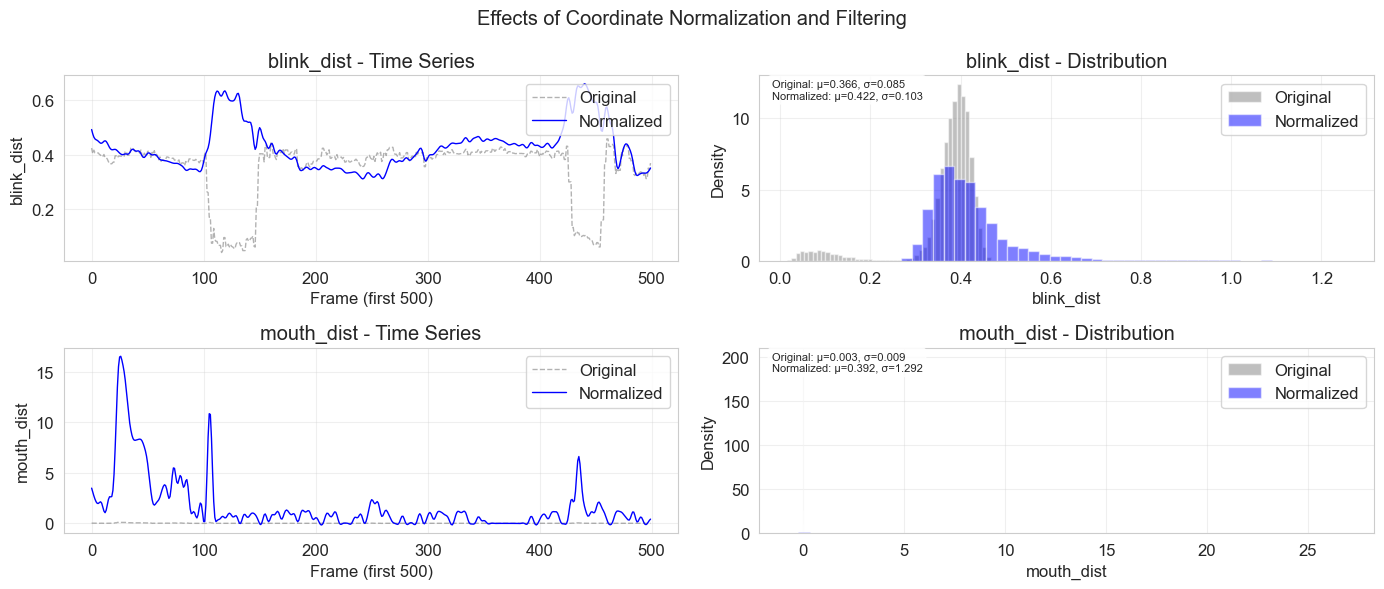

In [5]:
# Create detailed normalization comparison plots
if 'df_processed' in locals() and 'df_raw' in locals() and df_raw is not None:
    print("Creating detailed normalization comparison...")
    
    # Select features to compare
    comparison_features = ['blink_dist', 'mouth_dist', 'head_rotation_angle']
    comparison_features = [f for f in comparison_features if f in df_processed.columns and f in df_raw.columns]
    
    if comparison_features:
        # Create comparison plot
        plot_normalization_comparison(
            df_raw,
            df_processed,
            comparison_features[:2],  # Compare first 2 features for clarity
            title="Effects of Coordinate Normalization and Filtering",
            save_path=os.path.join(FIGURES_DIR, "normalization_effects.png")
        )
        
        print("\nNormalization effects:")
        print("  - Left plots show time series (first 500 frames)")
        print("  - Right plots show distribution changes")
        print("  - Statistics (μ=mean, σ=std) show quantitative differences")
        print("\nKey observations:")
        print("  - Procrustes alignment removes head pose variations")
        print("  - Temporal filtering smooths high-frequency noise")
        print("  - Scale normalization standardizes feature ranges")
    else:
        print("No common features found for comparison")
else:
    print("Original data not available for comparison - run the pipeline first")

## 4. Generate Final Report

Create summary statistics and export data for statistical analysis.

In [6]:
# Generate comprehensive analysis report
if 'output_paths' in locals():
    print("ANALYSIS COMPLETE")
    print("=" * 50)
    print("\nKey outputs:")
    for key, path in output_paths.items():
        if path and os.path.exists(path):
            print(f"  {key}: {path}")
    
    print("\n✓ Facial pose analysis pipeline completed successfully!")
    print("\nNext steps:")
    print("1. Review quality control results in the QC directory")
    print("2. Load feature data from the feature_data directory")
    print("3. Incorporate experimental condition labels for statistical analysis")
    print("4. Use the processing reports to understand data quality")
    
else:
    print("Pipeline was not executed. Please ensure data files are available and run the cells above.")

ANALYSIS COMPLETE

Key outputs:
  qc_dir: data/processed/quality_control
  feature_dir: data/processed/feature_data
  reports_dir: data/processed/reports
  keypoint_qc: data/processed/quality_control/keypoint_bad_windows.csv
  metric_qc: data/processed/quality_control/metric_bad_windows.csv
  bad_windows: data/processed/quality_control/metric_bad_window_indices.csv
  processing_report: data/processed/reports/processing_report.csv
  summary: data/processed/reports/processing_summary.txt

✓ Facial pose analysis pipeline completed successfully!

Next steps:
1. Review quality control results in the QC directory
2. Load feature data from the feature_data directory
3. Incorporate experimental condition labels for statistical analysis
4. Use the processing reports to understand data quality


## 5. Enhanced Feature Extraction Example

The pipeline supports flexible feature extraction with per-feature control over coordinate normalization and nose-relative gaze features.

In [7]:
# Example: Flexible feature extraction with per-feature Procrustes control
from utils.feature_extraction import extract_features_flexible

# Configuration for different features
feature_config = {
    'blink_dist': True,          # Use Procrustes for blink detection (more stable)
    'mouth_dist': False,         # Use original coordinates for mouth (speech analysis)
    'pupils': True,              # Use Procrustes for pupil tracking
    'head_rotation_angle': False # Use raw coordinates for head rotation
}

print("FLEXIBLE FEATURE EXTRACTION EXAMPLES")
print("=" * 50)

# Example 1: Extract specific features with mixed Procrustes settings
if 'csv_files' in locals() and csv_files:
    sample_file = os.path.join(RAW_DATA_DIR, csv_files[0])
    if os.path.exists(sample_file):
        print(f"\nExample 1: Mixed Procrustes configuration")
        print(f"Sample file: {csv_files[0]}")
        
        # Load sample data
        df_sample = pd.read_csv(sample_file)
        
        # Extract features with flexible configuration
        features_mixed = extract_all_features(
            df_sample,
            use_procrustes=False,  # Default to original
            feature_procrustes_config=feature_config,
            pupil_relative_to_nose=True  # Enable nose-relative pupil features
        )
        
        print(f"  Extracted {len(features_mixed.columns)} features")
        
        # Show which pupil features were created
        pupil_cols = [col for col in features_mixed.columns if 'pupil' in col]
        print(f"  Pupil features ({len(pupil_cols)}): {pupil_cols[:5]}...")
        
        # Show nose-relative features
        nose_rel_cols = [col for col in features_mixed.columns if 'rel_nose' in col]
        if nose_rel_cols:
            print(f"  Nose-relative features ({len(nose_rel_cols)}): {nose_rel_cols}")


FLEXIBLE FEATURE EXTRACTION EXAMPLES

Example 1: Mixed Procrustes configuration
Sample file: 3101_01_pose.csv
  Extracted 35 features
  Pupil features (18): ['left_pupil_x', 'left_pupil_y', 'left_pupil_prob', 'right_pupil_x', 'right_pupil_y']...
  Nose-relative features (7): ['left_pupil_rel_nose_x', 'left_pupil_rel_nose_y', 'right_pupil_rel_nose_x', 'right_pupil_rel_nose_y', 'avg_pupil_rel_nose_x', 'avg_pupil_rel_nose_y', 'avg_pupil_rel_nose_magnitude']


## 6. Statistical Analysis and Group Comparisons

This section performs statistical analysis comparing features across experimental conditions. It includes descriptive statistics, statistical tests, and publication-ready visualizations.

In [8]:
# Load processed pose data with proper condition mapping
# Path to participant information file
PARTICIPANT_INFO_PATH = "../data/participant_info.csv"

# Check if we have processed features to analyze
if 'output_paths' in locals() and 'feature_dir' in output_paths:
    FEATURE_DATA_DIR = output_paths['feature_dir']
else:
    # Fallback to default location
    FEATURE_DATA_DIR = "feature_data"

print("LOADING POSE DATA WITH EXPERIMENTAL CONDITIONS")
print("=" * 60)

# Check if participant info file exists
if os.path.exists(PARTICIPANT_INFO_PATH):
    # Load participant information
    participant_info = load_participant_info(PARTICIPANT_INFO_PATH)
    print(f"Loaded participant info for {len(participant_info)} participants")
    
    # Display counterbalancing summary
    condition_map = parse_condition_mapping(participant_info)
    print(f"Valid condition mappings for {len(condition_map)} participants")
    
    # Show counterbalancing summary
    print("\nCounterbalancing summary:")
    for session in [2, 3]:  # Sessions 2 and 3 are counterbalanced
        conditions_in_session = []
        for p_id, trials in condition_map.items():
            if session in trials:
                conditions_in_session.append(trials[session])
        
        if conditions_in_session:
            condition_counts = pd.Series(conditions_in_session).value_counts()
            print(f"  Session {session}: {condition_counts.to_dict()}")

    # Load pose data with conditions if feature directory exists
    if os.path.exists(FEATURE_DATA_DIR):
        df_with_conditions = load_pose_data_with_conditions(
            FEATURE_DATA_DIR,
            PARTICIPANT_INFO_PATH
        )
        
        if not df_with_conditions.empty:
            print(f"\nLoaded data summary:")
            print(f"  Total frames: {len(df_with_conditions):,}")
            print(f"  Participants: {df_with_conditions['participant'].nunique()}")
            print(f"  Trials per participant: {df_with_conditions.groupby('participant')['trial'].nunique().mean():.1f}")
            print(f"  Condition distribution:")
            for condition, count in df_with_conditions['condition'].value_counts().items():
                print(f"    {condition}: {count:,} frames")
            
            # Set this as our analysis dataset
            df_processed = df_with_conditions
        else:
            print("No data was loaded successfully")
            df_processed = None
    else:
        print(f"Feature directory not found: {FEATURE_DATA_DIR}")
        print("Run the pipeline first to generate feature data")
        df_processed = None
        
else:
    print(f"Participant info file not found: {PARTICIPANT_INFO_PATH}")
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    n_samples = 1000
    
    # Simulate features with different means for each condition
    df_processed = pd.DataFrame({
        'blink_dist': np.concatenate([
            np.random.normal(0.25, 0.05, n_samples // 3),  # Low
            np.random.normal(0.20, 0.05, n_samples // 3),  # Moderate
            np.random.normal(0.15, 0.05, n_samples // 3 + n_samples % 3)  # High
        ]),
        'mouth_dist': np.concatenate([
            np.random.normal(10, 2, n_samples // 3),  # Low
            np.random.normal(12, 2, n_samples // 3),  # Moderate
            np.random.normal(15, 2, n_samples // 3 + n_samples % 3)  # High
        ]),
        'head_rotation_angle': np.concatenate([
            np.random.normal(0, 0.1, n_samples // 3),  # Low
            np.random.normal(0, 0.15, n_samples // 3),  # Moderate
            np.random.normal(0, 0.2, n_samples // 3 + n_samples % 3)  # High
        ]),
        'condition': ['Low'] * (n_samples // 3) + 
                    ['Moderate'] * (n_samples // 3) + 
                    ['High'] * (n_samples // 3 + n_samples % 3),
        'participant': 'P001',
        'trial': 1,
        'minute': np.repeat(range(n_samples // 60 + 1), 60)[:n_samples]
    })
    
    print("Created synthetic data for demonstration")
    print(f"Data shape: {df_processed.shape}")

LOADING POSE DATA WITH EXPERIMENTAL CONDITIONS
Loaded participant info for 50 participants
Valid condition mappings for 49 participants

Counterbalancing summary:
  Session 2: {'Moderate': 25, 'High': 24}
  Session 3: {'High': 25, 'Moderate': 24}
Loaded 5 files with 152992 total frames
Participants: 2
Conditions: {'Low': 61197, 'Moderate': 61197, 'High': 30598}

Loaded data summary:
  Total frames: 152,992
  Participants: 2
  Trials per participant: 2.5
  Condition distribution:
    Low: 61,197 frames
    Moderate: 61,197 frames
    High: 30,598 frames


### Real Experimental Design and Data Loading

This section demonstrates how to load actual pose data with proper experimental condition mapping based on:
- **Participant Info**: Stored in `/data/participant_info.csv` 
- **File Structure**: `PPPP_TT_pose.csv` (Participant_Trial_pose.csv)
- **Condition Design**: 
  - Low (L) workload always in Trial 1
  - Moderate (M) and High (H) counterbalanced across Trials 2 and 3
  - Each participant has unique counterbalancing order

### Data Aggregation Options

The data can be analyzed at different temporal resolutions depending on research questions:

In [9]:
# Demonstrate different aggregation levels for analysis
if df_processed is not None and not df_processed.empty:
    print("DATA AGGREGATION OPTIONS")
    print("=" * 50)
    
    # Option 1: Frame-level analysis (most detailed)
    print("1. Frame-level analysis:")
    print(f"   - {len(df_processed):,} individual frames")
    print(f"   - Highest temporal resolution")
    print(f"   - Good for: temporal dynamics, detailed behavior analysis")
    
    # Option 2: Minute-level aggregation 
    if 'minute' in df_processed.columns:
        minute_data = df_processed.groupby(['participant', 'condition', 'minute']).agg({
            'blink_dist': 'mean',
            'mouth_dist': 'mean', 
            'head_rotation_angle': 'mean'
        }).reset_index()
        
        print(f"\n2. Minute-level aggregation:")
        print(f"   - {len(minute_data)} minute-blocks")
        print(f"   - Reduced noise, temporal trends preserved")
        print(f"   - Good for: time-course analysis, fatigue effects")
    
    # Option 3: Participant-condition level (most common for statistical analysis)
    if 'participant' in df_processed.columns:
        participant_level = df_processed.groupby(['participant', 'condition']).agg({
            'blink_dist': 'mean',
            'mouth_dist': 'mean',
            'head_rotation_angle': 'mean'
        }).reset_index()
        
        print(f"\n3. Participant-condition level:")
        print(f"   - {len(participant_level)} participant-condition combinations")
        print(f"   - Standard for between-subjects statistical tests")
        print(f"   - Good for: group comparisons, individual differences")
        
        # Show the data structure
        print(f"\nExample participant-condition data structure:")
        if len(participant_level) > 0:
            print(participant_level.head())
    
    # Recommendation
    print(f"\n" + "="*50)
    print("RECOMMENDATION:")
    print("For statistical analysis of group differences:")
    print("→ Use participant-condition level aggregation")
    print("→ This provides one data point per participant per condition")
    print("→ Appropriate for repeated-measures ANOVA or mixed-effects models")
    
else:
    print("No processed data available for aggregation demonstration")

DATA AGGREGATION OPTIONS
1. Frame-level analysis:
   - 152,992 individual frames
   - Highest temporal resolution
   - Good for: temporal dynamics, detailed behavior analysis

2. Minute-level aggregation:
   - 45 minute-blocks
   - Reduced noise, temporal trends preserved
   - Good for: time-course analysis, fatigue effects

3. Participant-condition level:
   - 5 participant-condition combinations
   - Standard for between-subjects statistical tests
   - Good for: group comparisons, individual differences

Example participant-condition data structure:
  participant condition  blink_dist  mouth_dist  head_rotation_angle
0        3101      High    0.447348    2.762311             0.038519
1        3101       Low    0.421613    0.391538             0.036677
2        3101  Moderate    0.440547    0.792479             0.031683
3        3102       Low    0.359035    1.260502            -0.060541
4        3102  Moderate    0.383447    0.640610            -0.026474

RECOMMENDATION:
For statist

### Calculate Summary Statistics by Condition

In [10]:
# Calculate comprehensive summary statistics
features_to_analyze = ['blink_dist', 'mouth_dist', 'head_rotation_angle']

# Get summary statistics by condition
summaries = calculate_feature_summary_by_condition(
    df_processed,
    features_to_analyze,
    condition_column='condition',
    participant_column='participant',
    time_column='minute'
)

# Display overall summary by condition
print("SUMMARY STATISTICS BY CONDITION")
print("=" * 60)

summary_by_cond = summaries['by_condition']
for feature in features_to_analyze:
    print(f"\n{feature}:")
    feature_data = summary_by_cond[summary_by_cond['feature'] == feature]
    
    for _, row in feature_data.iterrows():
        print(f"  {row['condition']:10} Mean: {row['mean']:.4f} ± {row['sem']:.4f} (n={row['n']:,})")
        print(f"  {'':10} Median: {row['median']:.4f}, IQR: [{row['q25']:.4f}, {row['q75']:.4f}]")

SUMMARY STATISTICS BY CONDITION

blink_dist:
  Low        Mean: 0.3903 ± 0.0004 (n=61,195)
             Median: 0.3775, IQR: [0.3265, 0.4316]
  Moderate   Mean: 0.4120 ± 0.0020 (n=61,197)
             Median: 0.3911, IQR: [0.3470, 0.4443]
  High       Mean: 0.4473 ± 0.0008 (n=30,598)
             Median: 0.4051, IQR: [0.3603, 0.4973]

mouth_dist:
  Low        Mean: 0.8260 ± 0.0107 (n=61,197)
             Median: 0.0789, IQR: [-0.0008, 0.6196]
  Moderate   Mean: 0.7165 ± 0.0117 (n=61,197)
             Median: 0.2899, IQR: [0.0016, 0.7765]
  High       Mean: 2.7623 ± 0.0238 (n=30,598)
             Median: 0.7605, IQR: [0.0402, 3.8263]

head_rotation_angle:
  Low        Mean: -0.0119 ± 0.0002 (n=61,197)
             Median: -0.0090, IQR: [-0.0616, 0.0416]
  Moderate   Mean: 0.0026 ± 0.0002 (n=61,197)
             Median: 0.0052, IQR: [-0.0289, 0.0365]
  High       Mean: 0.0385 ± 0.0002 (n=30,598)
             Median: 0.0440, IQR: [0.0219, 0.0563]


### Statistical Testing Across Conditions

In [11]:
# Perform statistical analysis for each feature
statistical_results = perform_feature_analysis(
    df_processed,
    features_to_analyze,
    group_column='condition',
    participant_column='participant'
)

print("STATISTICAL ANALYSIS RESULTS")
print("=" * 60)
print("\nOmnibus Tests (comparing all conditions):")
print("-" * 40)

for _, row in statistical_results.iterrows():
    feature = row['feature']
    test = row['test_used']
    p_value = row['p_value']
    effect_size = row.get('effect_size', np.nan)
    effect_type = row.get('effect_size_type', 'N/A')
    
    print(f"\n{feature}:")
    print(f"  Test: {test}")
    print(f"  p-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
    
    if not np.isnan(effect_size):
        print(f"  Effect size ({effect_type}): {effect_size:.4f}")

# Display pairwise comparisons if available
print("\n\nPairwise Comparisons (Bonferroni corrected):")
print("-" * 40)

# Get detailed comparison results for each feature
for feature in features_to_analyze:
    comparison_result = compare_groups_statistical(df_processed, feature, 'condition')
    
    print(f"\n{feature}:")
    
    if 'pairwise_comparisons' in comparison_result:
        for comp_name, comp_data in comparison_result['pairwise_comparisons'].items():
            groups = comp_name.replace('_vs_', ' vs ')
            p_val = comp_data['p_value_corrected']
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
            print(f"  {groups:20} p = {p_val:.6f} {sig}")

STATISTICAL ANALYSIS RESULTS

Omnibus Tests (comparing all conditions):
----------------------------------------

blink_dist:
  Test: Kruskal-Wallis H
  p-value: 0.000000 ***

mouth_dist:
  Test: Kruskal-Wallis H
  p-value: 0.000000 ***

head_rotation_angle:
  Test: Kruskal-Wallis H
  p-value: 0.000000 ***


Pairwise Comparisons (Bonferroni corrected):
----------------------------------------

blink_dist:
  Low vs Moderate      p = 0.000000 ***
  Low vs High          p = 0.000000 ***
  Moderate vs High     p = 0.000000 ***

mouth_dist:
  Low vs Moderate      p = 0.000000 ***
  Low vs High          p = 0.000000 ***
  Moderate vs High     p = 0.000000 ***

head_rotation_angle:
  Low vs Moderate      p = 0.000000 ***
  Low vs High          p = 0.000000 ***
  Moderate vs High     p = 0.000000 ***


### Statistical Bar Plots with Significance Brackets

Creating statistical bar plots...
Statistical bar plot saved to: output/figures/blink_dist_statistical_bars.png
Statistical bar plot saved to: output/figures/mouth_dist_statistical_bars.png
Statistical bar plot saved to: output/figures/head_rotation_angle_statistical_bars.png


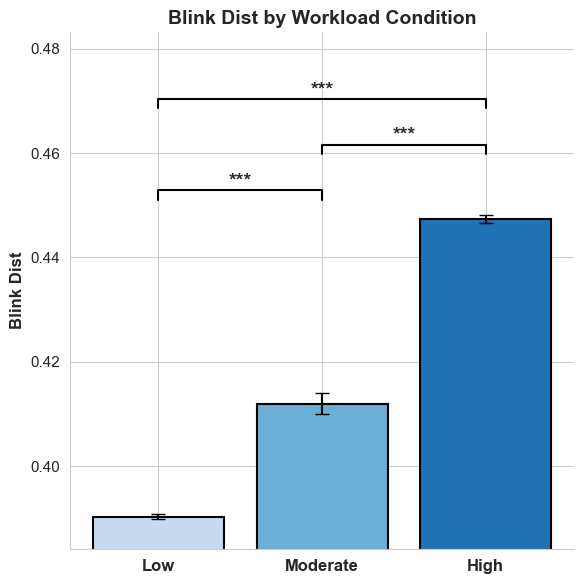

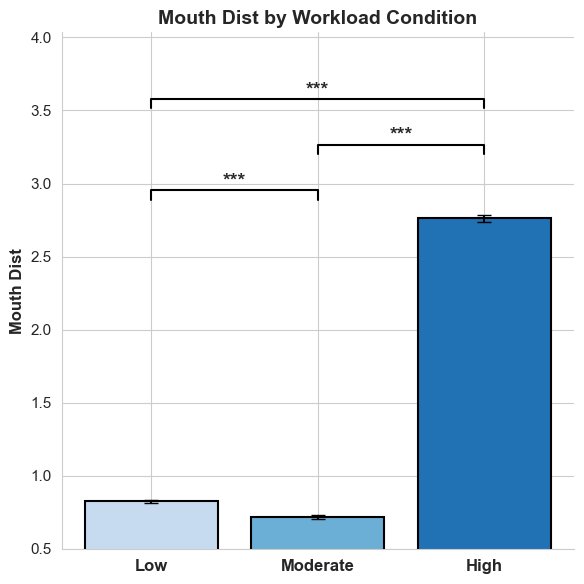

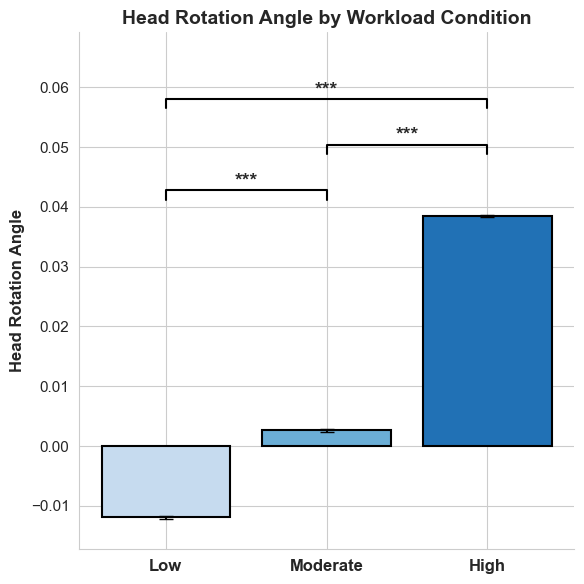

In [12]:
# Create publication-ready bar plots with significance brackets
print("Creating statistical bar plots...")

# Create individual plots for each feature
for feature in features_to_analyze:
    # Get statistics for this feature
    feature_stats = compare_groups_statistical(df_processed, feature, 'condition')
    
    # Prepare means and SEMs
    conditions = ['Low', 'Moderate', 'High']
    means = {}
    sems = {}
    
    for condition in conditions:
        if condition in feature_stats['group_statistics']:
            stats = feature_stats['group_statistics'][condition]
            means[condition] = stats['mean']
            sems[condition] = stats['sem']
    
    # Prepare p-values for brackets
    pvals = {}
    if 'pairwise_comparisons' in feature_stats:
        # Map comparison names to condition pairs
        for comp_name, comp_data in feature_stats['pairwise_comparisons'].items():
            if 'Low_vs_Moderate' in comp_name:
                pvals[('Low', 'Moderate')] = comp_data['p_value']
            elif 'Low_vs_High' in comp_name:
                pvals[('Low', 'High')] = comp_data['p_value']
            elif 'Moderate_vs_High' in comp_name:
                pvals[('Moderate', 'High')] = comp_data['p_value']
    
    # Create the plot
    plot_statistical_bars(
        means=means,
        sems=sems,
        pvals=pvals,
        ylabel=feature.replace('_', ' ').title(),
        title=f'{feature.replace("_", " ").title()} by Workload Condition',
        figsize=(6, 6),
        save_path=os.path.join(FIGURES_DIR, f'{feature}_statistical_bars.png')
    )

### Combined Feature Comparison Matrix

Feature comparison matrix saved to: output/figures/feature_comparison_matrix.png

Statistical analysis complete!

Key findings:
----------------------------------------
✓ blink_dist: Significant difference across conditions (p=0.0000)
  → Feature increases with workload
     Low: 0.3903, Moderate: 0.4120, High: 0.4473
✓ mouth_dist: Significant difference across conditions (p=0.0000)
  → Feature increases with workload
     Low: 0.8260, Moderate: 0.7165, High: 2.7623
✓ head_rotation_angle: Significant difference across conditions (p=0.0000)
  → Feature increases with workload
     Low: -0.0119, Moderate: 0.0026, High: 0.0385


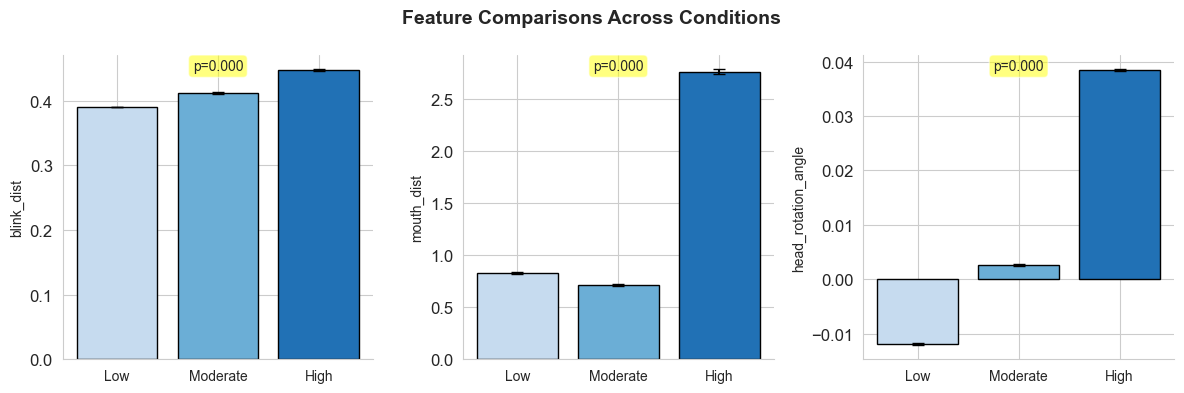

In [13]:
# Create a matrix plot showing all features at once
plot_feature_comparison_matrix(
    statistical_results,
    features_to_analyze,
    ['Low', 'Moderate', 'High'],
    figsize=(12, 4),
    save_path=os.path.join(FIGURES_DIR, 'feature_comparison_matrix.png')
)

print("\nStatistical analysis complete!")
print("\nKey findings:")
print("-" * 40)

# Summarize significant findings
for _, row in statistical_results.iterrows():
    feature = row['feature']
    p_value = row['p_value']
    
    if p_value < 0.05:
        print(f"✓ {feature}: Significant difference across conditions (p={p_value:.4f})")
        
        # Show direction of change
        mean_low = row.get('mean_Low', np.nan)
        mean_mod = row.get('mean_Moderate', np.nan)
        mean_high = row.get('mean_High', np.nan)
        
        if not np.isnan(mean_low) and not np.isnan(mean_high):
            direction = "increases" if mean_high > mean_low else "decreases"
            print(f"  → Feature {direction} with workload")
            print(f"     Low: {mean_low:.4f}, Moderate: {mean_mod:.4f}, High: {mean_high:.4f}")
    else:
        print(f"× {feature}: No significant difference (p={p_value:.4f})")